Sentiment Analysis

In [ ]:
import requests
import pandas as pd
from datetime import timedelta, date
import random
# Creating a function for date ranges
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)
# Defining a function to collect data from Stockwits API
def get_stockwits_data(symbol):
    url = f"https://api.stocktwits.com/api/2/streams/symbol/{symbol}.json"
    headers = {
        "Accept": "application/json"
    }
    response = requests.get(url, headers=headers)
    data = response.json()
    messages = data.get('messages', [])
    if messages:
        comment = random.choice(messages).get('body') # Select a random comment
        return comment
    return None

def main():
    start_date = date(2018, 1, 2)
    end_date = date(2023, 6, 29)
    symbol = "MANU"

    all_data = []

    for single_date in daterange(start_date, end_date):
        comment = get_stockwits_data(symbol)
        if comment:
            all_data.append({
                "Date": single_date.strftime("%Y-%m-%d"),
                "Comment": comment
            })

    df = pd.DataFrame(all_data)
    df.to_csv("stocktwits_data_5_years.csv", index=False)

if __name__ == "__main__":
    main()


Data preprocessing

In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
# Defining a function to preprocess data
def preprocess_text(text):
    # Removed URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Removed special characters
    text = re.sub(r'\$\w*', '', text)
    text = re.sub(r'\b\w{1,2}\b', '', text)
    # Converted to lowercase
    text = text.lower()
    # Removed punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenized
    words = word_tokenize(text)
    # Removed stopwords and lemmatized
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(words)

df = pd.read_csv('stocktwits_data_5_years.csv')
df['Comment'] = df['Comment'].apply(preprocess_text)
df.to_csv("stocktwits_data_5_years_cleaned.csv", index = False)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
!pip install transformers   # Installed transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 62.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 118.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.5 MB/s eta 0:00:00


In [ ]:
import torch
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request

# Preprocessed text
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

def sentiment(text):
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    for i in range(scores.shape[0]):
        l = labels[ranking[i]]
        s = scores[ranking[i]]
        return l

task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

# Downloaded label mapping
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

model = AutoModelForSequenceClassification.from_pretrained(MODEL)

df['sentiment'] = df['Comment'].apply(lambda x: sentiment(x))
df.to_csv('stocktwits_data_5_years_with_sentiment_RoBerTa.csv', index = False)


Conbining two csv based on date

In [ ]:
import pandas as pd

# Loaded the two datasets
sentiment_data = pd.read_csv('stocktwits_data_5_years_with_sentiment_RoBerTa.csv', parse_dates=['Date'])
stock_price_data = pd.read_csv('MANU_5_years.csv', parse_dates=['Date'])

# Merged the two datasets on 'Date' column
merged_data = pd.merge(stock_price_data, sentiment_data, on='Date')

# Saved the merged data to a new csv file
merged_data.to_csv('merged_data_5_years.csv', index=False)

Sentiment scoring

In [ ]:
import pandas as pd

# Loaded the merged dataset
merged_data = pd.read_csv('merged_data_5_years.csv')

# Created a dictionary to map sentiment to score
sentiment_score_map = {'positive': 1, 'negative': -1, 'neutral': 0}

# Created a new column 'sentiment_score' by mapping the 'sentiment' column using the dictionary
merged_data['sentiment_score'] = merged_data['sentiment'].map(sentiment_score_map)

# Saved the dataframe with the new column to the same csv file
merged_data.to_csv('merged_data_5_years_Sentiment_Scored.csv', index=False)


Similarly extracting data for future predictions

In [ ]:
import requests
import pandas as pd
from datetime import timedelta, date
import random

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

def get_stockwits_data(symbol):
    url = f"https://api.stocktwits.com/api/2/streams/symbol/{symbol}.json"
    headers = {
        "Accept": "application/json"
    }
    response = requests.get(url, headers=headers)
    data = response.json()
    messages = data.get('messages', [])
    if messages:
        comment = random.choice(messages).get('body') # Select a random comment
        return comment
    return None

def main():
    start_date = date(2023, 7, 1)
    end_date = date(2023, 7, 26)
    symbol = "MANU"

    all_data = []

    for single_date in daterange(start_date, end_date):
        comment = get_stockwits_data(symbol)
        if comment:
            all_data.append({
                "Date": single_date.strftime("%Y-%m-%d"),
                "Comment": comment
            })

    df = pd.DataFrame(all_data)
    df.to_csv("stocktwits_data_future_prediction.csv", index=False)

if __name__ == "__main__":
    main()


In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\$\w*', '', text)
    text = re.sub(r'\b\w{1,2}\b', '', text)
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(words)

df = pd.read_csv('stocktwits_data_future_prediction.csv')
df['Comment'] = df['Comment'].apply(preprocess_text)
df.to_csv("stocktwits_data_future_prediction_cleaned.csv", index = False)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
import torch
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request

def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

def sentiment(text):
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    for i in range(scores.shape[0]):
        l = labels[ranking[i]]
        s = scores[ranking[i]]
        return l

task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

model = AutoModelForSequenceClassification.from_pretrained(MODEL)

df['sentiment'] = df['Comment'].apply(lambda x: sentiment(x))
df.to_csv('stocktwits_data_future_prediction_with_sentiment_RoBerTa.csv', index = False)


In [ ]:
import pandas as pd

sentiment_data = pd.read_csv('stocktwits_data_future_prediction_with_sentiment_RoBerTa.csv', parse_dates=['Date'])
stock_price_data = pd.read_csv('MANU_future_prediction.csv', parse_dates=['Date'])
merged_data = pd.merge(stock_price_data, sentiment_data, on='Date')
merged_data.to_csv('merged_data_future_prediction.csv', index=False)

In [ ]:
import pandas as pd
merged_data = pd.read_csv('merged_data_future_prediction.csv')
sentiment_score_map = {'positive': 1, 'negative': -1, 'neutral': 0}
merged_data['sentiment_score'] = merged_data['sentiment'].map(sentiment_score_map)
merged_data.to_csv('merged_data_future_prediction_Sentiment_Scored.csv', index=False)


LSTM model


In [ ]:
!pip install pandas numpy sklearn tensorflow keras tensorflow keras-tuner matplotlib

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 4.2 MB/s eta 0:00:00
  Created wheel for sklearn: filename=sklearn-0.0.post7-py3-none-any.whl size=2950 sha256=98a949e2c2b8efd31de6d3356eee60c04b6472a1243fa296957ca04e67d9b80e
  Stored in directory: /root/.cache/pip/wheels/c8/9c/85/72901eb50bc4bc6e3b2629378d172384ea3dfd19759c77fd2c
Successfully built sklearn


Trial 10 Complete [00h 00m 24s]
val_loss: 0.00030594436490597826

Best val_loss So Far: 0.000255838754431655
Total elapsed time: 00h 04m 10s
Epoch 1/50
35/35 [==============================] - 5s 30ms/step - loss: 0.0187 - val_loss: 0.0023
Epoch 2/50
35/35 [==============================] - 0s 9ms/step - loss: 0.0012 - val_loss: 4.6220e-04
Epoch 3/50
35/35 [==============================] - 0s 7ms/step - loss: 6.5930e-04 - val_loss: 3.6945e-04
Epoch 4/50
35/35 [==============================] - 0s 9ms/step - loss: 6.0455e-04 - val_loss: 7.2987e-04
Epoch 5/50
35/35 [==============================] - 0s 8ms/step - loss: 5.4591e-04 - val_loss: 2.6855e-04
Epoch 6/50
35/35 [==============================] - 0s 7ms/step - loss: 4.4549e-04 - val_loss: 2.1131e-04
Epoch 7/50
35/35 [==============================] - 0s 9ms/step - loss: 4.7624e-04 - val_loss: 1.8604e-04
Epoch 8/50
35/35 [==============================] - 0s 8ms/step - loss: 4.7075e-04 - val_loss: 4.1997e-04
Epoch 9/50
35/35 [====

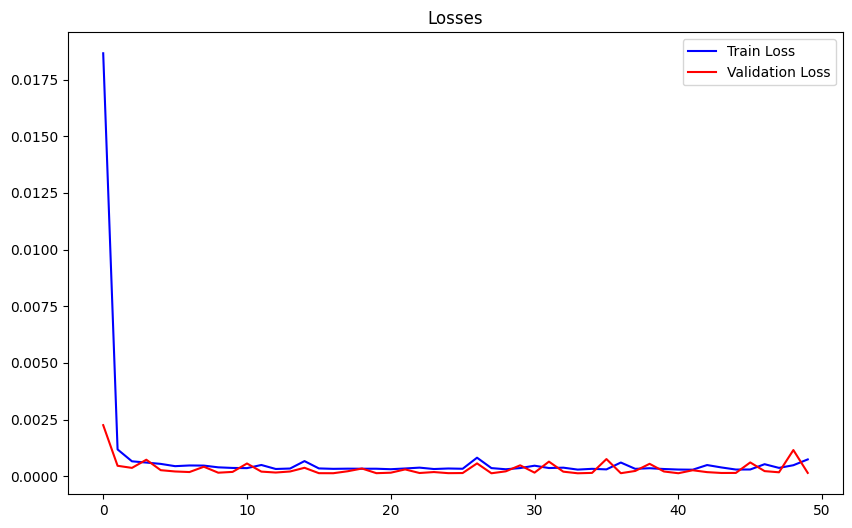

9/9 [==============================] - 1s 4ms/step
MSE: 0.039466851434037865, RMSE: 0.19866265737183186, MAPE: 0.8434384501165243%
Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
Epoch 1/50
35/35 [==============================] - 5s 29ms/step - loss: 0.0175 - val_loss: 0.0018
Epoch 2/50
35/35 [==============================] - 0s 8ms/step - loss: 9.2096e-04 - val_loss: 7.8323e-04
Epoch 3/50
35/35 [==============================] - 0s 7ms/step - loss: 6.8955e-04 - val_loss: 5.6642e-04
Epoch 4/50
35/35 [==============================] - 0s 7ms/step - loss: 5.6706e-04 - val_loss: 4.6104e-04
Epoch 5/50
35/35 [==============================] - 0s 9ms/step - loss: 5.1122e-04 - val_loss: 3.9319e-04
Epoch 6/50
35/35 [==============================] - 0s 8m

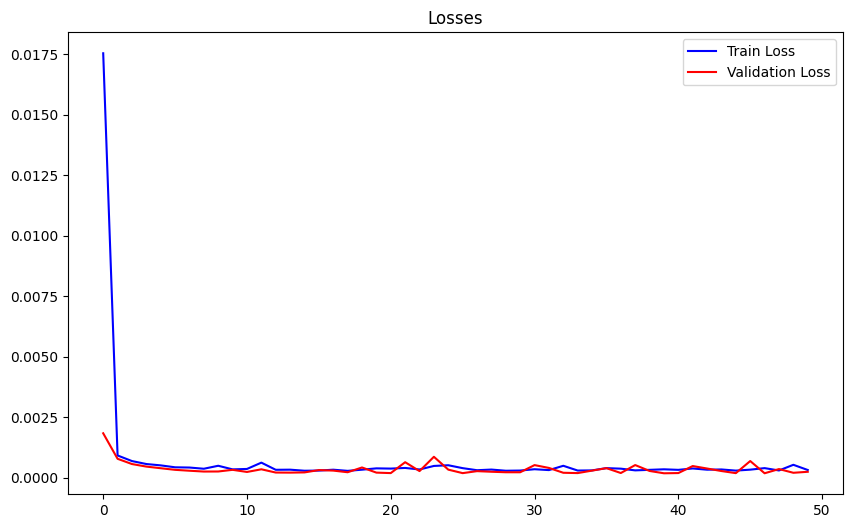

9/9 [==============================] - 1s 3ms/step
MSE: 0.06566355779397479, RMSE: 0.25624901520586335, MAPE: 1.0741742710799338%
Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
Epoch 1/50
35/35 [==============================] - 5s 31ms/step - loss: 0.0178 - val_loss: 0.0011
Epoch 2/50
35/35 [==============================] - 0s 8ms/step - loss: 8.2150e-04 - val_loss: 6.9105e-04
Epoch 3/50
35/35 [==============================] - 0s 9ms/step - loss: 7.3895e-04 - val_loss: 6.1436e-04
Epoch 4/50
35/35 [==============================] - 0s 9ms/step - loss: 6.1663e-04 - val_loss: 4.5261e-04
Epoch 5/50
35/35 [==============================] - 0s 9ms/step - loss: 4.8543e-04 - val_loss: 3.5561e-04
Epoch 6/50
35/35 [==============================] - 0s 8ms

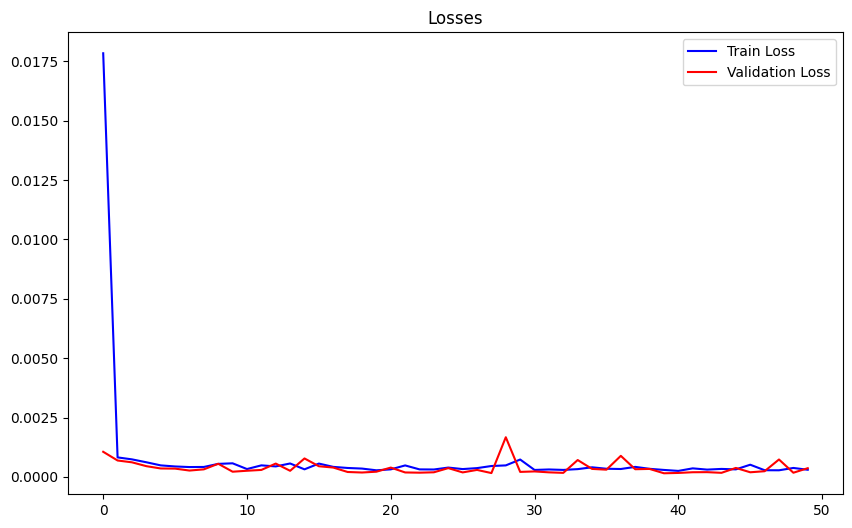

9/9 [==============================] - 1s 3ms/step
MSE: 0.09784513660732956, RMSE: 0.3128020725751822, MAPE: 1.4828519977950898%
Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
Epoch 1/50
35/35 [==============================] - 6s 30ms/step - loss: 0.0175 - val_loss: 0.0017
Epoch 2/50
35/35 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 5.7806e-04
Epoch 3/50
35/35 [==============================] - 0s 8ms/step - loss: 7.1488e-04 - val_loss: 4.3258e-04
Epoch 4/50
35/35 [==============================] - 0s 9ms/step - loss: 6.9243e-04 - val_loss: 3.5380e-04
Epoch 5/50
35/35 [==============================] - 0s 8ms/step - loss: 4.4847e-04 - val_loss: 3.0314e-04
Epoch 6/50
35/35 [==============================] - 0s 8ms/step

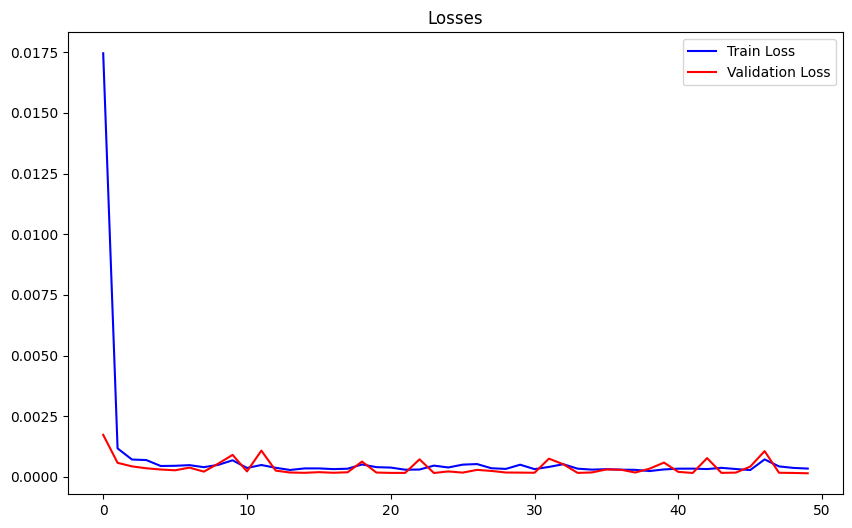

9/9 [==============================] - 1s 3ms/step
MSE: 0.03945712060876966, RMSE: 0.19863816503574952, MAPE: 0.7970961095469847%
Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
Epoch 1/50
35/35 [==============================] - 5s 31ms/step - loss: 0.0185 - val_loss: 6.9316e-04
Epoch 2/50
35/35 [==============================] - 0s 8ms/step - loss: 0.0010 - val_loss: 5.1400e-04
Epoch 3/50
35/35 [==============================] - 0s 8ms/step - loss: 7.0526e-04 - val_loss: 4.4722e-04
Epoch 4/50
35/35 [==============================] - 0s 9ms/step - loss: 5.1312e-04 - val_loss: 3.8955e-04
Epoch 5/50
35/35 [==============================] - 0s 8ms/step - loss: 4.6203e-04 - val_loss: 3.5889e-04
Epoch 6/50
35/35 [==============================] - 0s 7ms

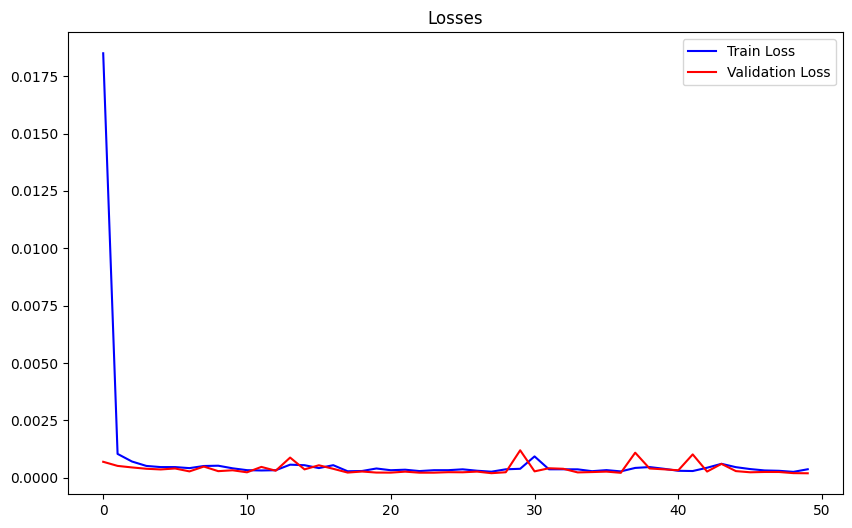

9/9 [==============================] - 1s 4ms/step
MSE: 0.051299330161263264, RMSE: 0.2264935543481608, MAPE: 0.878888822244028%
1/1 [==============================] - 0s 20ms/step
[[24.307518]
 [24.498987]
 [24.016857]
 [24.129635]
 [23.51154 ]
 [22.942827]
 [22.69436 ]
 [22.969086]
 [23.013872]
 [23.243252]
 [23.881926]
 [22.79879 ]
 [21.926668]
 [21.75069 ]
 [21.881458]
 [22.14715 ]]


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
import math
import matplotlib.pyplot as plt
from keras_tuner import RandomSearch
from keras_tuner.engine.hypermodel import HyperModel
df = pd.read_csv("merged_data_5_years_Sentiment_Scored.csv")
date_column = df['Date']
df.drop(columns=['Date'], inplace=True)
df.drop(columns=['Comment'], inplace=True)
df.drop(columns=['sentiment'], inplace=True)

# Preprocessed data
df.fillna(df.mean(), inplace=True)
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if np.isinf(df[col]).any():
        max_finite_value = df[~np.isinf(df[col])][col].max()
        df[col].replace([np.inf, -np.inf], max_finite_value, inplace=True)
X = df.drop(columns=['Close'])
y = df[['Close']]

# Normalized features and target
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaled_X = scaler_X.fit_transform(X)
scaled_y = scaler_y.fit_transform(y)

# Prepared data for LSTM model here
scaled_X = scaled_X.reshape((scaled_X.shape[0], scaled_X.shape[1], 1))

# Defined the hypermodel
class LSTMHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32),
                       input_shape=(scaled_X.shape[1], 1),
                       return_sequences=True))
        model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
        model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32)))
        model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model

hypermodel = LSTMHyperModel()

# Defined a Cross-validation function
def cross_validate(scaled_X, scaled_y):
    kfold = KFold(n_splits=5, shuffle=True)
    for train, test in kfold.split(scaled_X, scaled_y):
        X_train = scaled_X[train]
        y_train = scaled_y[train]
        X_test = scaled_X[test]
        y_test = scaled_y[test]

        tuner = RandomSearch(
            hypermodel,
            objective='val_loss',
            max_trials=10,
            executions_per_trial=3
        )

        tuner.search_space_summary()
        tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

        # Finding out the optimal hyperparameters
        best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
        # Building the model with the optimal hyperparameters
        model = tuner.hypermodel.build(best_hps)
        history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))
        # Calculating and print the losses
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
        print(f"Training Loss: {train_loss[-1]}")
        print(f"Validation Loss: {val_loss[-1]}")
        # Plotting the losses
        plt.figure(figsize=(10, 6))
        plt.plot(train_loss, color='blue', label='Train Loss')
        plt.plot(val_loss, color='red', label='Validation Loss')
        plt.title('Losses')
        plt.legend()
        plt.show()
        # Predicting the 'Close' prices
        y_pred = model.predict(X_test)
        # Reversed the scaling on the predictions
        y_pred_inverse = scaler_y.inverse_transform(y_pred)
        y_test_inverse = scaler_y.inverse_transform(y_test)
        # Calculating the performance metrics
        mse = mean_squared_error(y_test_inverse, y_pred_inverse)
        rmse = math.sqrt(mse)
        mape = np.mean(np.abs((y_test_inverse - y_pred_inverse) / y_test_inverse)) * 100
        print(f"MSE: {mse}, RMSE: {rmse}, MAPE: {mape}%")

    return model

model = cross_validate(scaled_X, scaled_y)

# Loading the future sentiment scores
future_df = pd.read_csv("merged_data_future_prediction_Sentiment_Scored.csv")

# Saved the 'Date' column for plotting later, and drop it from the DataFrame
date_future_column = future_df['Date']
future_df.drop(columns=['Date'], inplace=True)
future_df.drop(columns=['Comment'], inplace=True)
future_df.drop(columns=['sentiment'], inplace=True)
# Preprocess future data
future_df.fillna(future_df.mean(), inplace=True)
numeric_cols = future_df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if np.isinf(future_df[col]).any():
        max_finite_value = future_df[~np.isinf(future_df[col])][col].max()
        future_df[col].replace([np.inf, -np.inf], max_finite_value, inplace=True)

future_df = future_df.drop(columns=['Close'])

# Normalized the future data with the same scaler used on the original data
X_future = scaler_X.transform(future_df)

# Prepared the data for LSTM model
X_future = X_future.reshape((X_future.shape[0], X_future.shape[1], 1))
predicted_prices = model.predict(X_future)

# Reversed the scaling on the predictions
predicted_prices = scaler_y.inverse_transform(predicted_prices)
print(predicted_prices)

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
Epoch 1/50
35/35 [==============================] - 6s 29ms/step - loss: 0.0196 - val_loss: 0.0031
Epoch 2/50
35/35 [==============================] - 0s 7ms/step - loss: 0.0015 - val_loss: 7.2875e-04
Epoch 3/50
35/35 [==============================] - 0s 8ms/step - loss: 8.0435e-04 - val_loss: 5.3209e-04
Epoch 4/50
35/35 [==============================] - 0s 7ms/step - loss: 6.7561e-04 - val_loss: 4.4521e-04
Epoch 5/50
35/35 [==============================] - 0s 8ms/step - loss: 6.5268e-04 - val_loss: 3.8376e-04
Epoch 6/50
35/35 [==============================] - 0s 7ms/step - loss: 6.2675e-04 - val_loss: 3.9522e-04
Epoch 7/50
35/35 [==============================] - 0s 7ms/step - loss: 5.2698e-04 - v

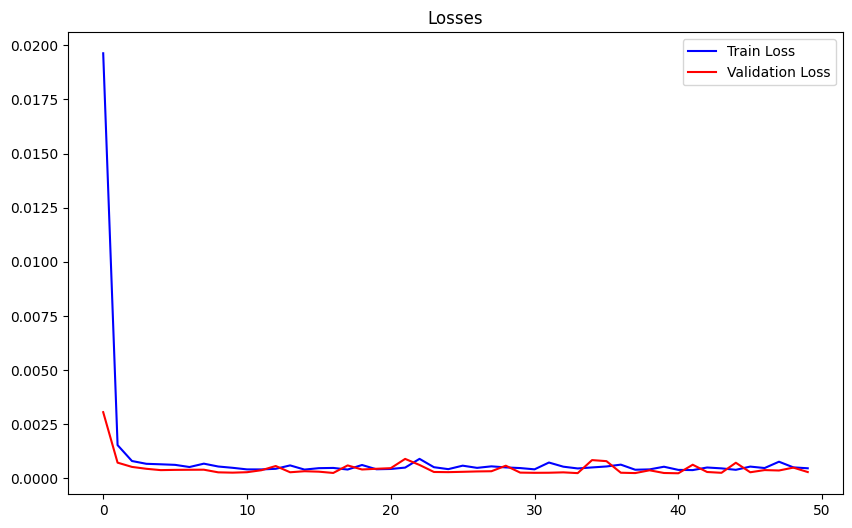

9/9 [==============================] - 1s 3ms/step
MSE: 0.07857929420735685, RMSE: 0.2803199853869803, MAPE: 1.2393811982753387%
Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
Epoch 1/50
35/35 [==============================] - 5s 29ms/step - loss: 0.0197 - val_loss: 8.6851e-04
Epoch 2/50
35/35 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 8.2686e-04
Epoch 3/50
35/35 [==============================] - 0s 9ms/step - loss: 7.6030e-04 - val_loss: 6.3419e-04
Epoch 4/50
35/35 [==============================] - 0s 14ms/step - loss: 6.3082e-04 - val_loss: 5.4649e-04
Epoch 5/50
35/35 [==============================] - 0s 14ms/step - loss: 5.4415e-04 - val_loss: 4.4450e-04
Epoch 6/50
35/35 [==============================] - 0s 8m

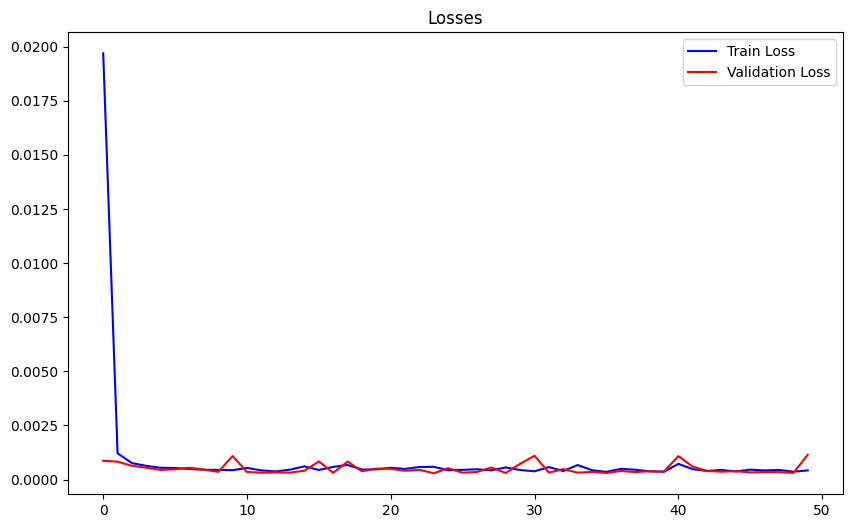

9/9 [==============================] - 1s 3ms/step
MSE: 0.3055588483320877, RMSE: 0.5527737768129813, MAPE: 2.5372556877637087%
Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
Epoch 1/50
35/35 [==============================] - 5s 34ms/step - loss: 0.0222 - val_loss: 0.0016
Epoch 2/50
35/35 [==============================] - 0s 10ms/step - loss: 0.0013 - val_loss: 8.2557e-04
Epoch 3/50
35/35 [==============================] - 0s 9ms/step - loss: 0.0010 - val_loss: 6.1879e-04
Epoch 4/50
35/35 [==============================] - 0s 10ms/step - loss: 7.9317e-04 - val_loss: 5.2887e-04
Epoch 5/50
35/35 [==============================] - 0s 11ms/step - loss: 6.7065e-04 - val_loss: 4.8325e-04
Epoch 6/50
35/35 [==============================] - 0s 10ms/step 

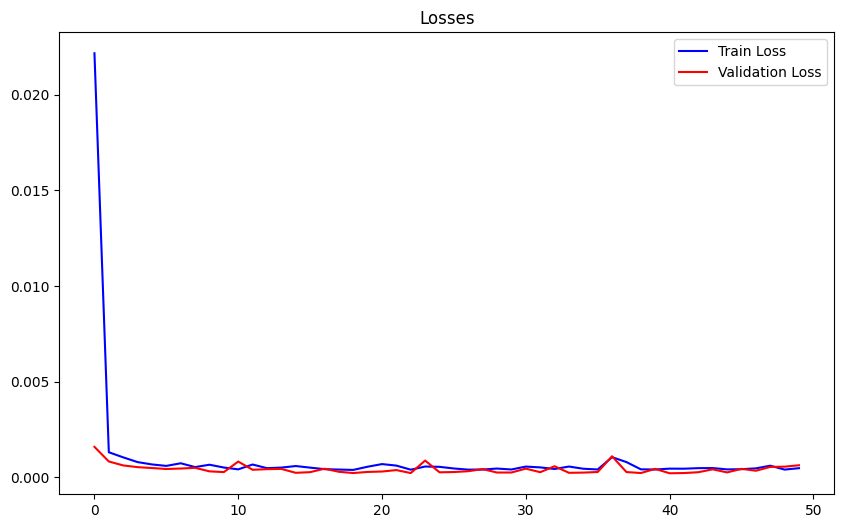

9/9 [==============================] - 1s 3ms/step
MSE: 0.16737307471162646, RMSE: 0.4091125452875119, MAPE: 1.825544202263187%
Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
Epoch 1/50
35/35 [==============================] - 6s 45ms/step - loss: 0.0189 - val_loss: 0.0010
Epoch 2/50
35/35 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 3/50
35/35 [==============================] - 0s 8ms/step - loss: 9.6348e-04 - val_loss: 6.5322e-04
Epoch 4/50
35/35 [==============================] - 0s 10ms/step - loss: 7.4047e-04 - val_loss: 9.2226e-04
Epoch 5/50
35/35 [==============================] - 0s 10ms/step - loss: 6.9155e-04 - val_loss: 4.4551e-04
Epoch 6/50
35/35 [==============================] - 0s 11ms/step -

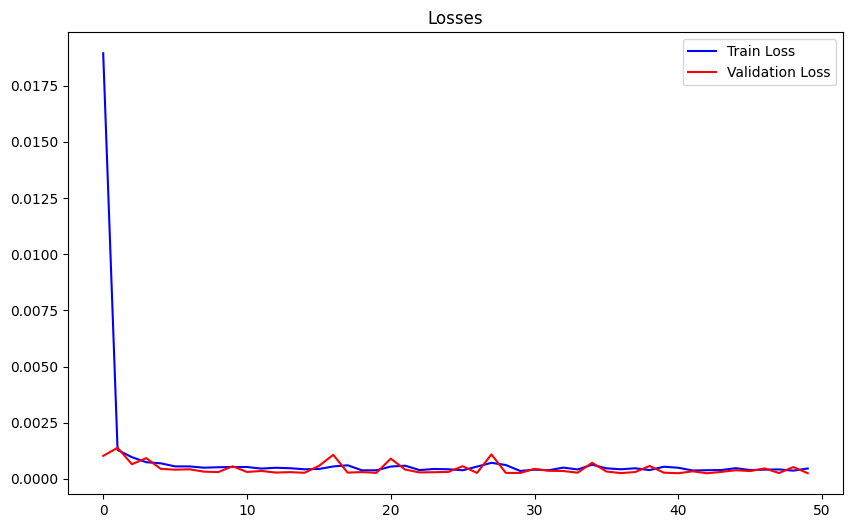

9/9 [==============================] - 1s 3ms/step
MSE: 0.06720159930520576, RMSE: 0.2592327126448469, MAPE: 1.047393141776503%
Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
Epoch 1/50
35/35 [==============================] - 5s 29ms/step - loss: 0.0214 - val_loss: 0.0029
Epoch 2/50
35/35 [==============================] - 0s 9ms/step - loss: 0.0013 - val_loss: 6.3707e-04
Epoch 3/50
35/35 [==============================] - 0s 8ms/step - loss: 7.3805e-04 - val_loss: 5.5061e-04
Epoch 4/50
35/35 [==============================] - 0s 8ms/step - loss: 6.9651e-04 - val_loss: 5.7696e-04
Epoch 5/50
35/35 [==============================] - 0s 8ms/step - loss: 5.8844e-04 - val_loss: 4.2133e-04
Epoch 6/50
35/35 [==============================] - 0s 7ms/step 

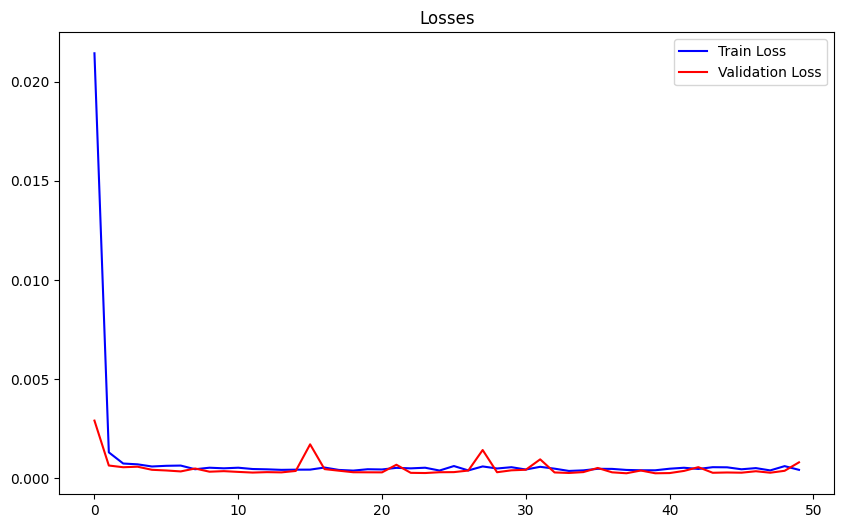

9/9 [==============================] - 1s 3ms/step
MSE: 0.2127302416673271, RMSE: 0.4612268874071926, MAPE: 2.06422924185398%
1/1 [==============================] - 0s 20ms/step
[[24.879442]
 [25.10346 ]
 [24.548552]
 [24.679745]
 [24.24981 ]
 [23.567001]
 [23.144485]
 [23.49519 ]
 [23.514929]
 [23.683388]
 [24.487047]
 [23.680016]
 [22.3845  ]
 [22.2849  ]
 [22.24074 ]
 [22.568949]]


In [ ]:
df = pd.read_csv("merged_data_5_years_Sentiment_Scored.csv")
date_column = df['Date']
df.drop(columns=['Date'], inplace=True)
df.drop(columns=['Comment'], inplace=True)
df.drop(columns=['sentiment'], inplace=True)
df.drop(columns=['Adj Close'], inplace=True)

# Preprocessing of the data
df.fillna(df.mean(), inplace=True)
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if np.isinf(df[col]).any():
        max_finite_value = df[~np.isinf(df[col])][col].max()
        df[col].replace([np.inf, -np.inf], max_finite_value, inplace=True)
X = df.drop(columns=['Close'])
y = df[['Close']]
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaled_X = scaler_X.fit_transform(X)
scaled_y = scaler_y.fit_transform(y)

scaled_X = scaled_X.reshape((scaled_X.shape[0], scaled_X.shape[1], 1))
class LSTMHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32),
                       input_shape=(scaled_X.shape[1], 1),
                       return_sequences=True))
        model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
        model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32)))
        model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model

hypermodel = LSTMHyperModel()

def cross_validate(scaled_X, scaled_y):
    kfold = KFold(n_splits=5, shuffle=True)
    for train, test in kfold.split(scaled_X, scaled_y):
        X_train = scaled_X[train]
        y_train = scaled_y[train]
        X_test = scaled_X[test]
        y_test = scaled_y[test]

        tuner = RandomSearch(
            hypermodel,
            objective='val_loss',
            max_trials=10,
            executions_per_trial=3
        )

        tuner.search_space_summary()

        tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))
        best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
        model = tuner.hypermodel.build(best_hps)

        history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
        print(f"Training Loss: {train_loss[-1]}")
        print(f"Validation Loss: {val_loss[-1]}")
        plt.figure(figsize=(10, 6))
        plt.plot(train_loss, color='blue', label='Train Loss')
        plt.plot(val_loss, color='red', label='Validation Loss')
        plt.title('Losses')
        plt.legend()
        plt.show()
        y_pred = model.predict(X_test)
        y_pred_inverse = scaler_y.inverse_transform(y_pred)
        y_test_inverse = scaler_y.inverse_transform(y_test)
        mse = mean_squared_error(y_test_inverse, y_pred_inverse)
        rmse = math.sqrt(mse)
        mape = np.mean(np.abs((y_test_inverse - y_pred_inverse) / y_test_inverse)) * 100

        print(f"MSE: {mse}, RMSE: {rmse}, MAPE: {mape}%")

    return model

model = cross_validate(scaled_X, scaled_y)

future_df = pd.read_csv("merged_data_future_prediction_Sentiment_Scored.csv")
date_future_column = future_df['Date']
future_df.drop(columns=['Date'], inplace=True)
future_df.drop(columns=['Comment'], inplace=True)
future_df.drop(columns=['sentiment'], inplace=True)
future_df.drop(columns=['Adj Close'], inplace=True)
future_df.fillna(future_df.mean(), inplace=True)
numeric_cols = future_df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if np.isinf(future_df[col]).any():
        max_finite_value = future_df[~np.isinf(future_df[col])][col].max()
        future_df[col].replace([np.inf, -np.inf], max_finite_value, inplace=True)
future_df = future_df.drop(columns=['Close'])
X_future = scaler_X.transform(future_df)
X_future = X_future.reshape((X_future.shape[0], X_future.shape[1], 1))
predicted_prices = model.predict(X_future)
predicted_prices = scaler_y.inverse_transform(predicted_prices)

print(predicted_prices)

TCN implementation

In [ ]:
!pip install keras-tcn  # Installing TCN

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 5.2 MB/s eta 0:00:00


Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
Epoch 1/50
35/35 [==============================] - 11s 28ms/step - loss: 0.5511 - val_loss: 0.0094
Epoch 2/50
35/35 [==============================] - 0s 8ms/step - loss: 0.1052 - val_loss: 0.0024
Epoch 3/50
35/35 [==============================] - 0s 8ms/step - loss: 0.0527 - val_loss: 0.0031
Epoch 4/50
35/35 [==============================] - 0s 8ms/step - loss: 0.0344 - val_loss: 6.8622e-04
Epoch 5/50
35/35 [==============================] - 0s 8ms/step - loss: 0.0202 - val_loss: 0.0010
Epoch 6/50
35/35 [==============================] - 0s 10ms/step - loss: 0.0162 - val_loss: 4.7882e-04
Epoch 7/50
35/35 [==============================] - 0s 8ms/step - loss: 0.0135 - val_loss: 7.9404e-04
Epoch 8/50

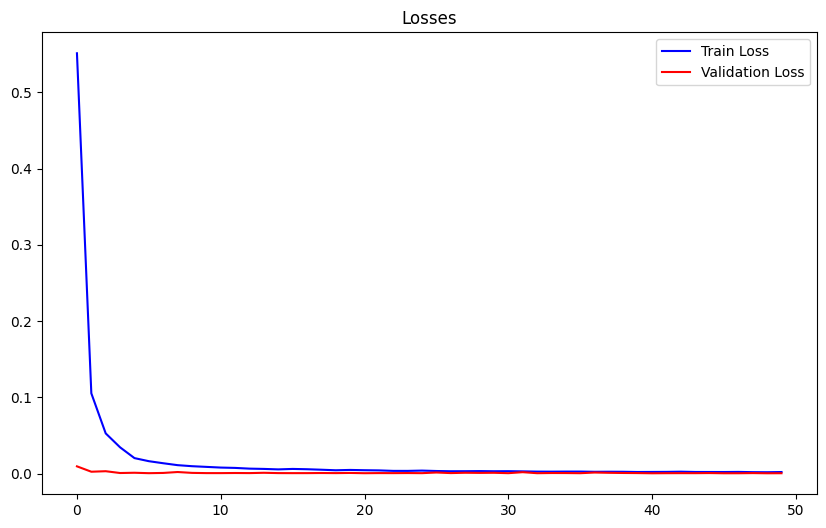

9/9 [==============================] - 0s 3ms/step
MSE: 0.10915371328786348, RMSE: 0.33038419043268924, MAPE: 1.277617576372225%
Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
Epoch 1/50
35/35 [==============================] - 5s 28ms/step - loss: 0.3963 - val_loss: 0.0033
Epoch 2/50
35/35 [==============================] - 0s 10ms/step - loss: 0.0775 - val_loss: 0.0023
Epoch 3/50
35/35 [==============================] - 0s 9ms/step - loss: 0.0506 - val_loss: 0.0025
Epoch 4/50
35/35 [==============================] - 0s 8ms/step - loss: 0.0380 - val_loss: 0.0035
Epoch 5/50
35/35 [==============================] - 0s 8ms/step - loss: 0.0258 - val_loss: 0.0015
Epoch 6/50
35/35 [==============================] - 0s 10ms/step - loss: 0.0195 - val_loss

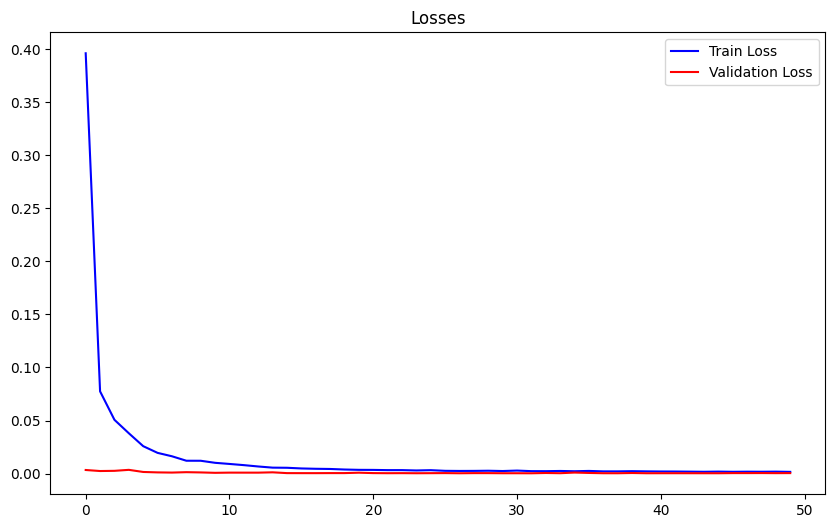

9/9 [==============================] - 0s 3ms/step
MSE: 0.10558791601847953, RMSE: 0.32494294271222374, MAPE: 1.1361099782466577%
Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
Epoch 1/50
35/35 [==============================] - 5s 17ms/step - loss: 0.5856 - val_loss: 0.0304
Epoch 2/50
35/35 [==============================] - 0s 8ms/step - loss: 0.1336 - val_loss: 0.0013
Epoch 3/50
35/35 [==============================] - 0s 9ms/step - loss: 0.0762 - val_loss: 0.0031
Epoch 4/50
35/35 [==============================] - 0s 10ms/step - loss: 0.0563 - val_loss: 7.1969e-04
Epoch 5/50
35/35 [==============================] - 0s 9ms/step - loss: 0.0344 - val_loss: 0.0012
Epoch 6/50
35/35 [==============================] - 0s 8ms/step - loss: 0.0256 - val_

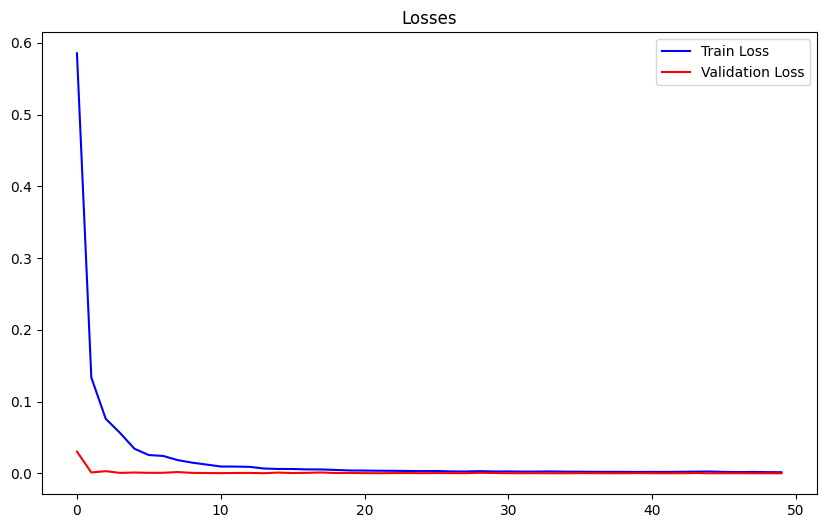

9/9 [==============================] - 0s 3ms/step
MSE: 0.051189218736417484, RMSE: 0.22625034527358734, MAPE: 0.9883702477809739%
Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
Epoch 1/50
35/35 [==============================] - 5s 21ms/step - loss: 0.1319 - val_loss: 0.0024
Epoch 2/50
35/35 [==============================] - 0s 12ms/step - loss: 0.0411 - val_loss: 0.0013
Epoch 3/50
35/35 [==============================] - 0s 12ms/step - loss: 0.0197 - val_loss: 7.2898e-04
Epoch 4/50
35/35 [==============================] - 0s 12ms/step - loss: 0.0138 - val_loss: 0.0011
Epoch 5/50
35/35 [==============================] - 0s 13ms/step - loss: 0.0110 - val_loss: 5.9010e-04
Epoch 6/50
35/35 [==============================] - 0s 13ms/step - loss: 0.00

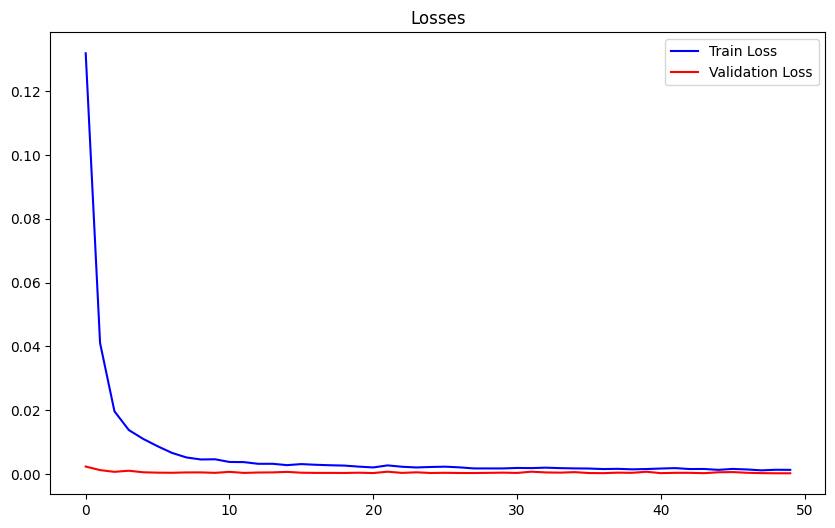

9/9 [==============================] - 0s 6ms/step
MSE: 0.07462126933342045, RMSE: 0.2731689391812701, MAPE: 1.1485686362083496%
Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
Epoch 1/50
35/35 [==============================] - 5s 18ms/step - loss: 5.7699 - val_loss: 0.0266
Epoch 2/50
35/35 [==============================] - 0s 9ms/step - loss: 0.4417 - val_loss: 0.0029
Epoch 3/50
35/35 [==============================] - 0s 8ms/step - loss: 0.2097 - val_loss: 0.0053
Epoch 4/50
35/35 [==============================] - 0s 10ms/step - loss: 0.1462 - val_loss: 0.0091
Epoch 5/50
35/35 [==============================] - 0s 13ms/step - loss: 0.1179 - val_loss: 0.0011
Epoch 6/50
35/35 [==============================] - 0s 13ms/step - loss: 0.1024 - val_los

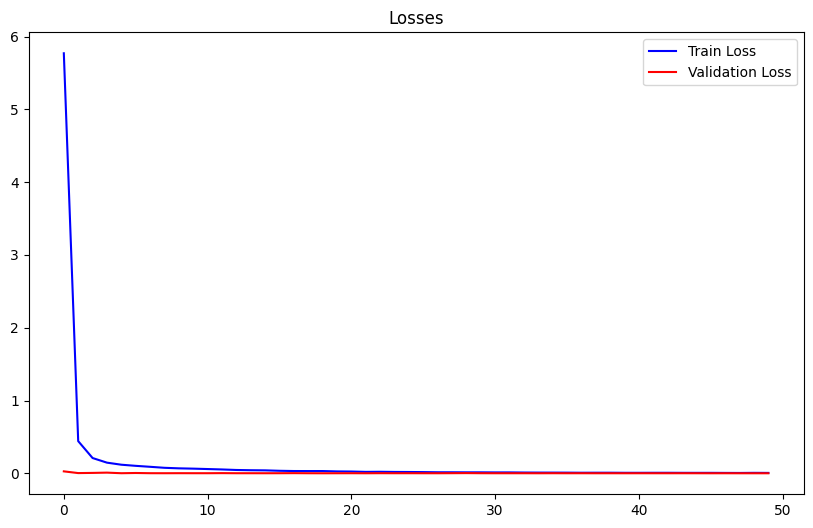

9/9 [==============================] - 0s 4ms/step
MSE: 0.06144386968846361, RMSE: 0.24787873988800171, MAPE: 1.0333550619654615%
1/1 [==============================] - 0s 24ms/step
[[24.784964]
 [25.024033]
 [24.263622]
 [24.607895]
 [23.594639]
 [23.135962]
 [22.852823]
 [22.756557]
 [23.183308]
 [23.405504]
 [24.213062]
 [22.312992]
 [22.112709]
 [21.657667]
 [22.002718]
 [22.409456]]


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras_tuner import RandomSearch
from tcn import TCN, tcn_full_summary
import math
import matplotlib.pyplot as plt
df = pd.read_csv("merged_data_5_years_Sentiment_Scored.csv")
date_column = df['Date']
df.drop(columns=['Date'], inplace=True)
df.drop(columns=['Comment'], inplace=True)
df.drop(columns=['sentiment'], inplace=True)
df.drop(columns=['Adj Close'], inplace=True)
df.fillna(df.mean(), inplace=True)
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if np.isinf(df[col]).any():
        max_finite_value = df[~np.isinf(df[col])][col].max()
        df[col].replace([np.inf, -np.inf], max_finite_value, inplace=True)
X = df.drop(columns=['Close'])
y = df[['Close']]

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaled_X = scaler_X.fit_transform(X)
scaled_y = scaler_y.fit_transform(y)
scaled_X = scaled_X.reshape((scaled_X.shape[0], scaled_X.shape[1], 1))

class TCNHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(TCN(input_shape=(scaled_X.shape[1], 1),
                      nb_filters=hp.Int('nb_filters', min_value=32, max_value=512, step=32),
                      kernel_size=hp.Int('kernel_size', min_value=2, max_value=6, step=1),
                      dilations=[1, 2, 4, 8],
                      return_sequences=False))
        model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model

hypermodel = TCNHyperModel()

def cross_validate(scaled_X, scaled_y):
    kfold = KFold(n_splits=5, shuffle=True)
    for train, test in kfold.split(scaled_X, scaled_y):
        X_train = scaled_X[train]
        y_train = scaled_y[train]
        X_test = scaled_X[test]
        y_test = scaled_y[test]

        tuner = RandomSearch(
            hypermodel,
            objective='val_loss',
            max_trials=10,
            executions_per_trial=3
        )

        tuner.search_space_summary()
        tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))
        best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
        model = tuner.hypermodel.build(best_hps)

        history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
        print(f"Training Loss: {train_loss[-1]}")
        print(f"Validation Loss: {val_loss[-1]}")
        plt.figure(figsize=(10, 6))
        plt.plot(train_loss, color='blue', label='Train Loss')
        plt.plot(val_loss, color='red', label='Validation Loss')
        plt.title('Losses')
        plt.legend()
        plt.show()
        y_pred = model.predict(X_test)
        y_pred_inverse = scaler_y.inverse_transform(y_pred)
        y_test_inverse = scaler_y.inverse_transform(y_test)
        mse = mean_squared_error(y_test_inverse, y_pred_inverse)
        rmse = math.sqrt(mse)
        mape = np.mean(np.abs((y_test_inverse - y_pred_inverse) / y_test_inverse)) * 100

        print(f"MSE: {mse}, RMSE: {rmse}, MAPE: {mape}%")

    return model

model = cross_validate(scaled_X, scaled_y)
future_df = pd.read_csv("merged_data_future_prediction_Sentiment_Scored.csv")
date_future_column = future_df['Date']
future_df.drop(columns=['Date'], inplace=True)
future_df.drop(columns=['Comment'], inplace=True)
future_df.drop(columns=['sentiment'], inplace=True)
future_df.drop(columns=['Adj Close'], inplace=True)
future_df.fillna(future_df.mean(), inplace=True)
numeric_cols = future_df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if np.isinf(future_df[col]).any():
        max_finite_value = future_df[~np.isinf(future_df[col])][col].max()
        future_df[col].replace([np.inf, -np.inf], max_finite_value, inplace=True)
future_df = future_df.drop(columns=['Close'])
X_future = scaler_X.transform(future_df)
X_future = X_future.reshape((X_future.shape[0], X_future.shape[1], 1))
predicted_prices = model.predict(X_future)
predicted_prices = scaler_y.inverse_transform(predicted_prices)

print(predicted_prices)


GRU implementation

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
Epoch 1/50
35/35 [==============================] - 5s 26ms/step - loss: 0.0200 - val_loss: 0.0030
Epoch 2/50
35/35 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 3.1436e-04
Epoch 3/50
35/35 [==============================] - 0s 11ms/step - loss: 4.6848e-04 - val_loss: 2.7763e-04
Epoch 4/50
35/35 [==============================] - 0s 10ms/step - loss: 4.5519e-04 - val_loss: 2.4058e-04
Epoch 5/50
35/35 [==============================] - 0s 9ms/step - loss: 3.9886e-04 - val_loss: 3.1941e-04
Epoch 6/50
35/35 [==============================] - 0s 10ms/step - loss: 5.1186e-04 - val_loss: 2.4040e-04
Epoch 7/50
35/35 [==============================] - 0s 10ms/step - loss: 4.3397e-04

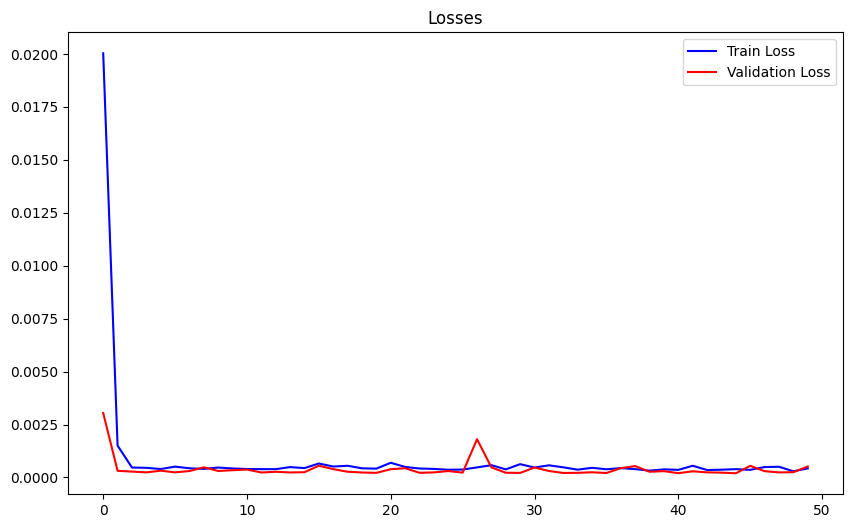

9/9 [==============================] - 1s 3ms/step
MSE: 0.13812652495662361, RMSE: 0.3716537702709655, MAPE: 1.600149879316708%
Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
Epoch 1/50
35/35 [==============================] - 5s 29ms/step - loss: 0.0172 - val_loss: 0.0014
Epoch 2/50
35/35 [==============================] - 0s 9ms/step - loss: 8.8519e-04 - val_loss: 6.3207e-04
Epoch 3/50
35/35 [==============================] - 0s 10ms/step - loss: 5.0721e-04 - val_loss: 2.5169e-04
Epoch 4/50
35/35 [==============================] - 0s 10ms/step - loss: 3.9847e-04 - val_loss: 3.3769e-04
Epoch 5/50
35/35 [==============================] - 0s 10ms/step - loss: 3.9896e-04 - val_loss: 2.7722e-04
Epoch 6/50
35/35 [==============================] - 0s 10

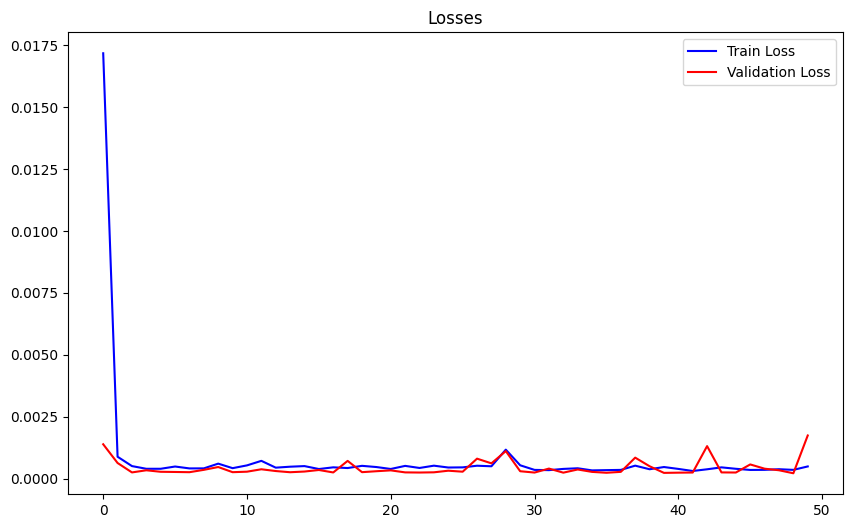

9/9 [==============================] - 1s 3ms/step
MSE: 0.46488940140019086, RMSE: 0.681827985198753, MAPE: 3.315031868629764%
Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
Epoch 1/50
35/35 [==============================] - 5s 25ms/step - loss: 0.0239 - val_loss: 0.0017
Epoch 2/50
35/35 [==============================] - 0s 9ms/step - loss: 0.0013 - val_loss: 3.3100e-04
Epoch 3/50
35/35 [==============================] - 0s 8ms/step - loss: 4.6464e-04 - val_loss: 2.6765e-04
Epoch 4/50
35/35 [==============================] - 0s 7ms/step - loss: 4.6741e-04 - val_loss: 5.3698e-04
Epoch 5/50
35/35 [==============================] - 0s 8ms/step - loss: 5.2065e-04 - val_loss: 2.7163e-04
Epoch 6/50
35/35 [==============================] - 0s 7ms/step -

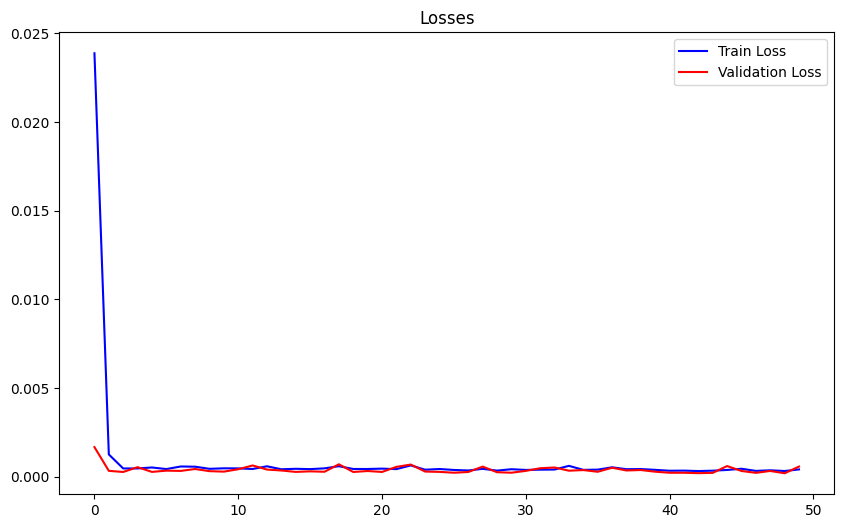

9/9 [==============================] - 1s 3ms/step
MSE: 0.15266689401392453, RMSE: 0.3907261112517623, MAPE: 1.7255853545436972%
Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
Epoch 1/50
35/35 [==============================] - 5s 28ms/step - loss: 0.0218 - val_loss: 0.0034
Epoch 2/50
35/35 [==============================] - 0s 8ms/step - loss: 0.0014 - val_loss: 5.8436e-04
Epoch 3/50
35/35 [==============================] - 0s 7ms/step - loss: 4.9161e-04 - val_loss: 4.7450e-04
Epoch 4/50
35/35 [==============================] - 0s 8ms/step - loss: 4.4904e-04 - val_loss: 3.6610e-04
Epoch 5/50
35/35 [==============================] - 0s 7ms/step - loss: 4.0603e-04 - val_loss: 3.5450e-04
Epoch 6/50
35/35 [==============================] - 0s 7ms/step

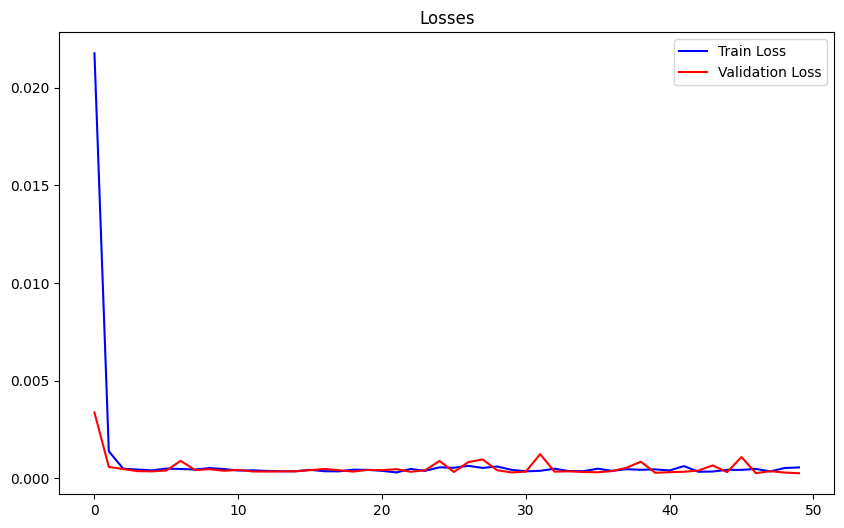

9/9 [==============================] - 1s 3ms/step
MSE: 0.06858889994200323, RMSE: 0.26189482610773973, MAPE: 1.0755398856300538%
Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
Epoch 1/50
35/35 [==============================] - 6s 26ms/step - loss: 0.0205 - val_loss: 0.0021
Epoch 2/50
35/35 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 2.6842e-04
Epoch 3/50
35/35 [==============================] - 0s 8ms/step - loss: 4.2738e-04 - val_loss: 4.2816e-04
Epoch 4/50
35/35 [==============================] - 0s 8ms/step - loss: 4.2439e-04 - val_loss: 2.7589e-04
Epoch 5/50
35/35 [==============================] - 0s 8ms/step - loss: 4.5904e-04 - val_loss: 2.8581e-04
Epoch 6/50
35/35 [==============================] - 0s 8ms/ste

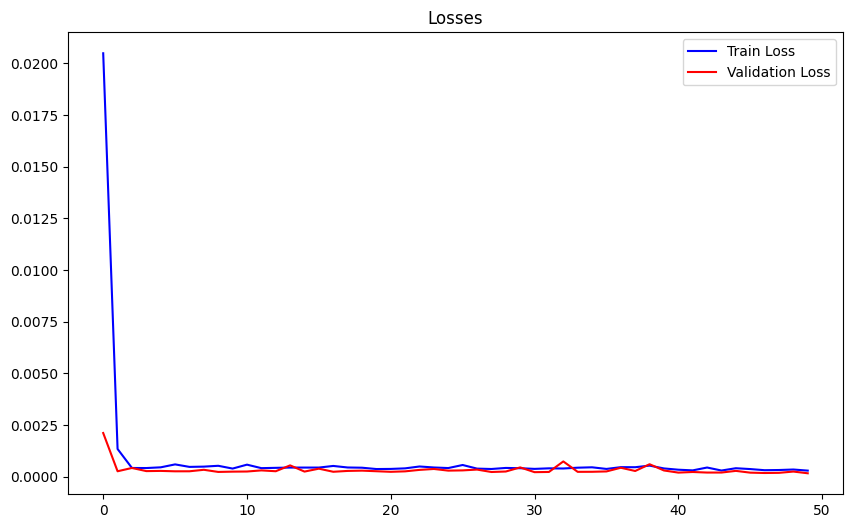

9/9 [==============================] - 1s 4ms/step
MSE: 0.045639016137300696, RMSE: 0.21363290040932528, MAPE: 0.8821468853350685%
1/1 [==============================] - 0s 29ms/step
[[24.354412]
 [24.577513]
 [23.974894]
 [24.158546]
 [23.584824]
 [22.98548 ]
 [22.619865]
 [22.829344]
 [22.923218]
 [23.194622]
 [23.887068]
 [22.873913]
 [21.900948]
 [21.708273]
 [21.764553]
 [22.109232]]


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from keras_tuner import RandomSearch
import math
import matplotlib.pyplot as plt
df = pd.read_csv("merged_data_5_years_Sentiment_Scored.csv")
date_column = df['Date']
df.drop(columns=['Date'], inplace=True)
df.drop(columns=['Comment'], inplace=True)
df.drop(columns=['sentiment'], inplace=True)
df.drop(columns=['Adj Close'], inplace=True)
df.fillna(df.mean(), inplace=True)
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if np.isinf(df[col]).any():
        max_finite_value = df[~np.isinf(df[col])][col].max()
        df[col].replace([np.inf, -np.inf], max_finite_value, inplace=True)

X = df.drop(columns=['Close'])
y = df[['Close']]
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaled_X = scaler_X.fit_transform(X)
scaled_y = scaler_y.fit_transform(y)
scaled_X = scaled_X.reshape((scaled_X.shape[0], scaled_X.shape[1], 1))

class GRUHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(GRU(units=hp.Int('units', min_value=32, max_value=512, step=32),
                      input_shape=(scaled_X.shape[1], 1),
                      return_sequences=True))
        model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
        model.add(GRU(units=hp.Int('units', min_value=32, max_value=512, step=32)))
        model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model

hypermodel = GRUHyperModel()

def cross_validate(scaled_X, scaled_y):
    kfold = KFold(n_splits=5, shuffle=True)
    for train, test in kfold.split(scaled_X, scaled_y):
        X_train = scaled_X[train]
        y_train = scaled_y[train]
        X_test = scaled_X[test]
        y_test = scaled_y[test]

        tuner = RandomSearch(
            hypermodel,
            objective='val_loss',
            max_trials=10,
            executions_per_trial=3
        )

        tuner.search_space_summary()
        tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))
        best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
        model = tuner.hypermodel.build(best_hps)
        history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
        print(f"Training Loss: {train_loss[-1]}")
        print(f"Validation Loss: {val_loss[-1]}")
        plt.figure(figsize=(10, 6))
        plt.plot(train_loss, color='blue', label='Train Loss')
        plt.plot(val_loss, color='red', label='Validation Loss')
        plt.title('Losses')
        plt.legend()
        plt.show()

        y_pred = model.predict(X_test)
        y_pred_inverse = scaler_y.inverse_transform(y_pred)
        y_test_inverse = scaler_y.inverse_transform(y_test)
        mse = mean_squared_error(y_test_inverse, y_pred_inverse)
        rmse = math.sqrt(mse)
        mape = np.mean(np.abs((y_test_inverse - y_pred_inverse) / y_test_inverse)) * 100

        print(f"MSE: {mse}, RMSE: {rmse}, MAPE: {mape}%")

    return model

model = cross_validate(scaled_X, scaled_y)

future_df = pd.read_csv("merged_data_future_prediction_Sentiment_Scored.csv")
date_future_column = future_df['Date']
future_df.drop(columns=['Date'], inplace=True)
future_df.drop(columns=['Comment'], inplace=True)
future_df.drop(columns=['sentiment'], inplace=True)
future_df.drop(columns=['Adj Close'], inplace=True)
future_df.fillna(future_df.mean(), inplace=True)
numeric_cols = future_df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if np.isinf(future_df[col]).any():
        max_finite_value = future_df[~np.isinf(future_df[col])][col].max()
        future_df[col].replace([np.inf, -np.inf], max_finite_value, inplace=True)

future_df = future_df.drop(columns=['Close'])
X_future = scaler_X.transform(future_df)
X_future = X_future.reshape((X_future.shape[0], X_future.shape[1], 1))
predicted_prices = model.predict(X_future)
predicted_prices = scaler_y.inverse_transform(predicted_prices)

print(predicted_prices)


1D CNN implementation

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
Epoch 1/50
35/35 [==============================] - 2s 10ms/step - loss: 0.0597 - val_loss: 0.0079
Epoch 2/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0041 - val_loss: 7.6471e-04
Epoch 3/50
35/35 [==============================] - 0s 6ms/step - loss: 0.0020 - val_loss: 4.0851e-04
Epoch 4/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 3.2689e-04
Epoch 5/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0013 - val_loss: 3.9399e-04
Epoch 6/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0011 - val_loss: 2.9639e-04
Epoch 7/50
35/35 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 3.9348e-04


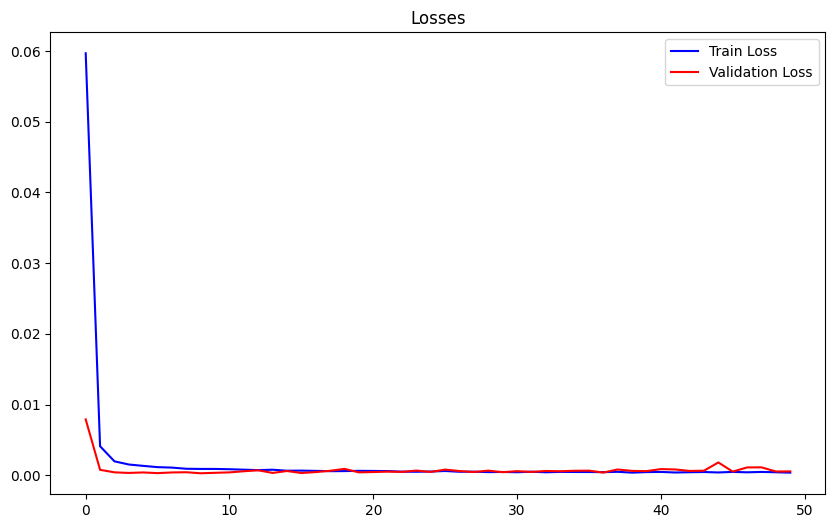

9/9 [==============================] - 0s 2ms/step
MSE: 0.145187931881084, RMSE: 0.38103534203677747, MAPE: 1.494697252386806%
Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
Epoch 1/50
35/35 [==============================] - 2s 11ms/step - loss: 0.0237 - val_loss: 0.0037
Epoch 2/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 2.8649e-04
Epoch 3/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 3.5189e-04
Epoch 4/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 2.8623e-04
Epoch 5/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0016 - val_loss: 2.0537e-04
Epoch 6/50
35/35 [==============================] - 0s 5ms/step - loss: 0.001

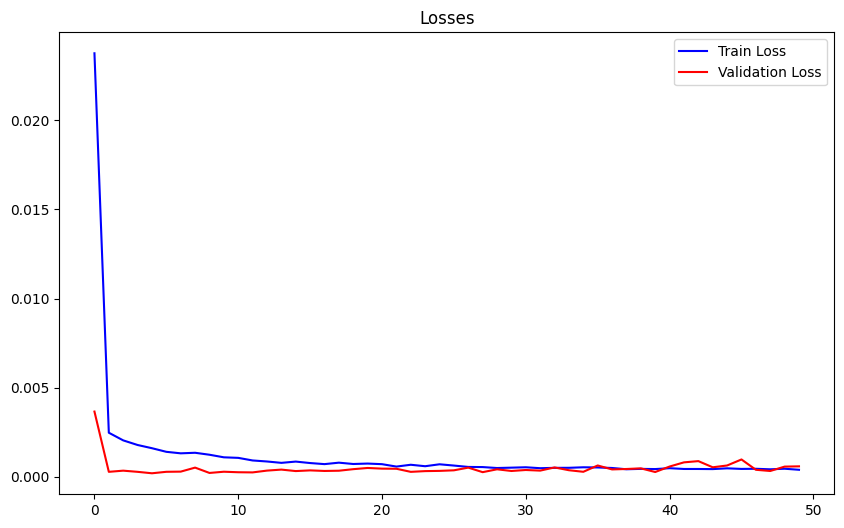

9/9 [==============================] - 0s 3ms/step
MSE: 0.15842917047736477, RMSE: 0.398031619946663, MAPE: 1.6516123033389143%
Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
Epoch 1/50
35/35 [==============================] - 1s 8ms/step - loss: 0.0985 - val_loss: 0.0135
Epoch 2/50
35/35 [==============================] - 0s 6ms/step - loss: 0.0081 - val_loss: 0.0042
Epoch 3/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0036 - val_loss: 9.8156e-04
Epoch 4/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 3.5762e-04
Epoch 5/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0016 - val_loss: 3.4355e-04
Epoch 6/50
35/35 [==============================] - 0s 4ms/step - loss: 0.0014 - 

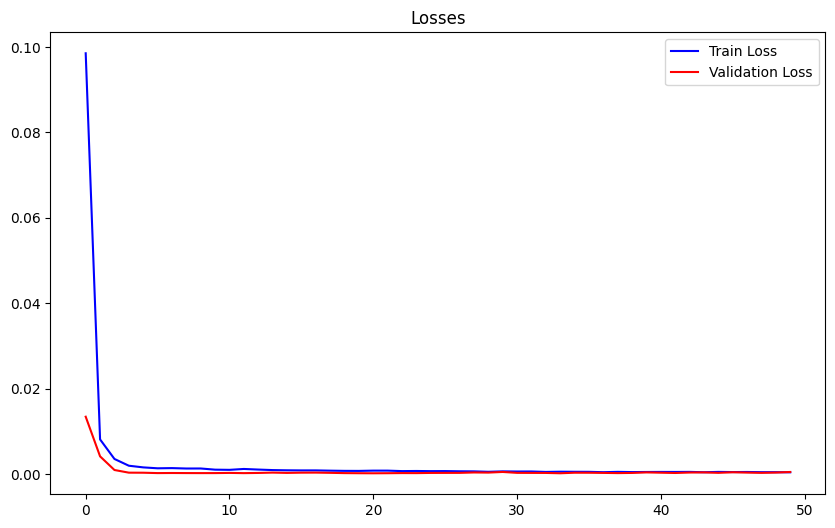

9/9 [==============================] - 0s 3ms/step
MSE: 0.1381143232340171, RMSE: 0.37163735446536733, MAPE: 1.5528235778852364%
Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
Epoch 1/50
35/35 [==============================] - 2s 8ms/step - loss: 0.0990 - val_loss: 0.0176
Epoch 2/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0093 - val_loss: 0.0017
Epoch 3/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0024 - val_loss: 4.1467e-04
Epoch 4/50
35/35 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 2.7662e-04
Epoch 5/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0017 - val_loss: 2.9737e-04
Epoch 6/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0013 -

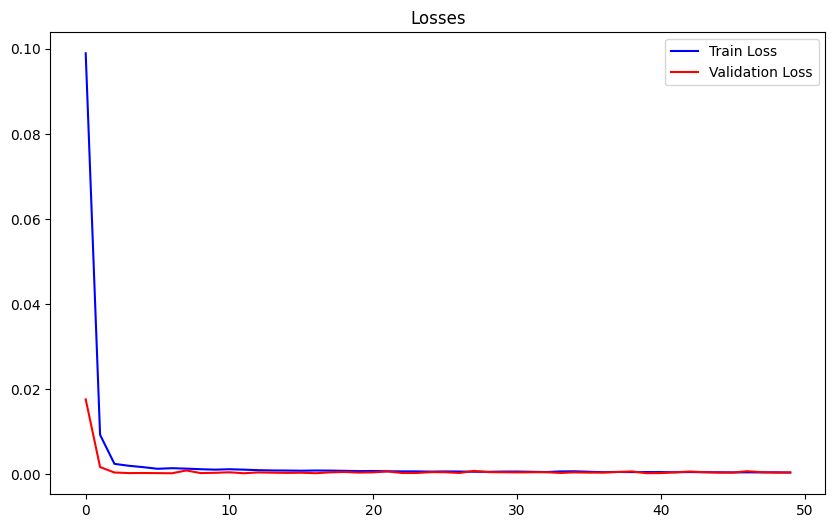

9/9 [==============================] - 0s 3ms/step
MSE: 0.11288507182310167, RMSE: 0.3359837374384386, MAPE: 1.3713230874935207%
Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
Epoch 1/50
35/35 [==============================] - 2s 8ms/step - loss: 0.0255 - val_loss: 0.0037
Epoch 2/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0038 - val_loss: 5.5635e-04
Epoch 3/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 4.8637e-04
Epoch 4/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 4.2320e-04
Epoch 5/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0017 - val_loss: 3.4640e-04
Epoch 6/50
35/35 [==============================] - 0s 4ms/step - loss: 0.00

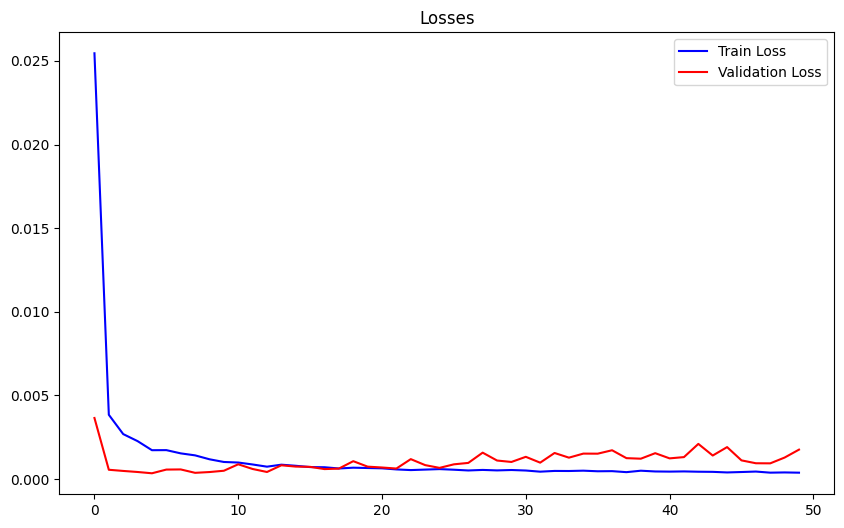

9/9 [==============================] - 0s 2ms/step
MSE: 0.4693305879143445, RMSE: 0.6850770671350374, MAPE: 3.127183284507651%
1/1 [==============================] - 0s 27ms/step
[[23.288218]
 [23.527155]
 [22.840588]
 [23.103159]
 [22.44359 ]
 [21.879461]
 [21.631964]
 [21.943392]
 [22.146715]
 [22.138544]
 [22.914577]
 [21.919725]
 [20.950676]
 [20.747868]
 [20.777157]
 [21.130198]]


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from keras_tuner import RandomSearch
import math
import matplotlib.pyplot as plt

df = pd.read_csv("merged_data_5_years_Sentiment_Scored.csv")
date_column = df['Date']
df.drop(columns=['Date'], inplace=True)
df.drop(columns=['Comment'], inplace=True)
df.drop(columns=['sentiment'], inplace=True)
df.drop(columns=['Adj Close'], inplace=True)
df.fillna(df.mean(), inplace=True)
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if np.isinf(df[col]).any():
        max_finite_value = df[~np.isinf(df[col])][col].max()
        df[col].replace([np.inf, -np.inf], max_finite_value, inplace=True)

X = df.drop(columns=['Close'])
y = df[['Close']]
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaled_X = scaler_X.fit_transform(X)
scaled_y = scaler_y.fit_transform(y)

scaled_X = scaled_X.reshape((scaled_X.shape[0], scaled_X.shape[1], 1))

class CNNHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(Conv1D(filters=hp.Int('filters', min_value=32, max_value=512, step=32),
                         kernel_size=hp.Int('kernel_size', min_value=2, max_value=10, step=1),
                         activation='relu',
                         input_shape=(scaled_X.shape[1], 1)))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
        model.add(Flatten())
        model.add(Dense(50, activation='relu'))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model

hypermodel = CNNHyperModel()

def cross_validate(scaled_X, scaled_y):
    kfold = KFold(n_splits=5, shuffle=True)
    for train, test in kfold.split(scaled_X, scaled_y):
        X_train = scaled_X[train]
        y_train = scaled_y[train]
        X_test = scaled_X[test]
        y_test = scaled_y[test]

        tuner = RandomSearch(
            hypermodel,
            objective='val_loss',
            max_trials=10,
            executions_per_trial=3
        )

        tuner.search_space_summary()

        tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))
        best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
        model = tuner.hypermodel.build(best_hps)

        history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
        print(f"Training Loss: {train_loss[-1]}")
        print(f"Validation Loss: {val_loss[-1]}")
        plt.figure(figsize=(10, 6))
        plt.plot(train_loss, color='blue', label='Train Loss')
        plt.plot(val_loss, color='red', label='Validation Loss')
        plt.title('Losses')
        plt.legend()
        plt.show()
        y_pred = model.predict(X_test)
        y_pred_inverse = scaler_y.inverse_transform(y_pred)
        y_test_inverse = scaler_y.inverse_transform(y_test)
        mse = mean_squared_error(y_test_inverse, y_pred_inverse)
        rmse = math.sqrt(mse)
        mape = np.mean(np.abs((y_test_inverse - y_pred_inverse) / y_test_inverse)) * 100

        print(f"MSE: {mse}, RMSE: {rmse}, MAPE: {mape}%")

    return model

model = cross_validate(scaled_X, scaled_y)

future_df = pd.read_csv("merged_data_future_prediction_Sentiment_Scored.csv")
date_future_column = future_df['Date']
future_df.drop(columns=['Date'], inplace=True)
future_df.drop(columns=['Comment'], inplace=True)
future_df.drop(columns=['sentiment'], inplace=True)
future_df.drop(columns=['Adj Close'], inplace=True)
future_df.fillna(future_df.mean(), inplace=True)
numeric_cols = future_df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if np.isinf(future_df[col]).any():
        max_finite_value = future_df[~np.isinf(future_df[col])][col].max()
        future_df[col].replace([np.inf, -np.inf], max_finite_value, inplace=True)

future_df = future_df.drop(columns=['Close'])
X_future = scaler_X.transform(future_df)
X_future = X_future.reshape((X_future.shape[0], X_future.shape[1], 1))
predicted_prices = model.predict(X_future)
predicted_prices = scaler_y.inverse_transform(predicted_prices)

print(predicted_prices)
